# Exercise Session 7: Image Segmentation

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage.transform import rescale, resize

## Q1 Adaptive Thresholding 

#### Task
Implement an adaptive thresholding algorithm to segment ``image_1`` based on the guidlines given below. Find appropriate parameters such that output looks similar to the example given Fig 1(right).  

#### Description
Let the input image be $I$ and the thresholded image be $J$. Then 

$$
J(x, y) =
\begin{cases}
1, & \text{if } I(x, y) \geq T(x, y) \\
0, & \text{otherwise}
\end{cases}
$$


where $x$, $y$ are the coordinates of the pixel and $T(x,y)$ is the threshold at this pixel. In a standard thresholding algorithm, $T(x,y) = C$. That is, all the pixels are thresholded with the same value. But when implementing adaptive threhsolding, you have to use a local statistic along with $C$ to compute $T(x,y)$.  



#### Note
- You are not allowed to use any library functions that perform adoptive thresholding. You have to implement the above equation.
- To get a better segmentation, try different values for C and other parameters in $T(x,y)$ 

<figure>
    <img src="images/book.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; " />
    <img src="images/book_threshed.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; "/>
    <figcaption>Figure 1: (Left) Input image. (Right) Output after performing adoptive thresholding. You need to find an appropriate threshold value for $C$ such that it looks similar to (or better than) this image..</figcaption>
</figure>

In [49]:
image_1 = io.imread("./images/book.png")
# -------------------------------
# Implement your code here
# -------------------------------
def adaptive_threshold(image, block_size=15, C=0.05):
    image = image.astype(np.float32) / 255.0
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    padded = np.pad(gray, block_size // 2, mode='reflect')
    output = np.zeros_like(gray)

    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            local_region = padded[i:i+block_size, j:j+block_size]
            T = np.mean(local_region) - C
            output[i, j] = 1 if gray[i, j] >= T else 0

    return output
# -------------------------------


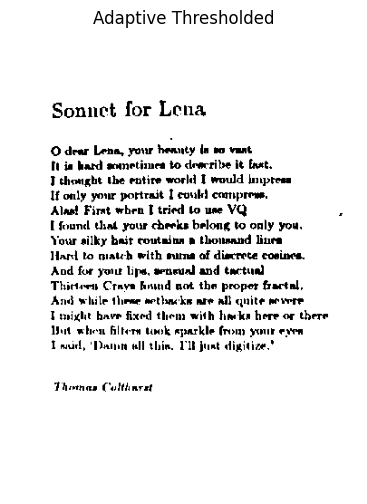

In [50]:
output_1 = adaptive_threshold(image_1, block_size=15, C=0.03)

plt.figure(figsize=(12, 6))
plt.imshow(output_1, cmap='gray')
plt.title("Adaptive Thresholded")
plt.axis("off")
plt.show()

## Q2 Mean Shift for Image Segmentation

#### Task
Implement mean shift algorithm to perform image segmentation. The input image is stored in ```image_2```.


#### Description

Meanshift algorithm is a mode-seeking algorithm, which tries to map each pixel inside the image into the nearest mode (or the nearest cluster center). Let input image be $X$ and $x$ be a single pixel in the image. Here, $x=[R,G,B]$ where $R,G,B$ represent values corresponding to the three color channels in the input image. Let $Y$ be the segmented image with same dimensions as $X$ and $y$ be a single pixel in the segmented image. Similar to $x$, $y$ also holds a R,G,B value, but it represents cluster centers obtained after running the mean-shift algorithm. 


At the beginning, $Y$ is initialized with the R,G,B value of the corresponding image pixels in $X$. Afterwards, every $y$ in $Y$ is updated (although independently) using mean-shift update.  Mean-shift updates can be described as taking the exponentially decaying weigted mean of all pixels. It is given by the equation

$$ y_{k+1} = y_k + m(y_{k}) =  \frac{\sum_{i} x_{i} G(y_k-x_i)}{ \sum_{i} G(y_k-x_i)},$$ 

The distance function $G$ can be described as
$$G(\mathbf{x})=\exp \left(-\left(\frac{R^{2}+G^{2}+B^{2}}{h^{2}}\right)\right),$$
It decays exponentially with the RGB distances of two pixels. $h$ is a parameter that determines the width of the kernel and you are free to choose an appropriate value for it. You also need to determine an appropriate number of iterations to perform mean-shift updates.

Note: 
- You are not allowed to use any library functions that perform mean-shift. You have to implement the above equations. 
- For h, you can use 0.2 (Assuming float image values between 0-1). Dependending on your implementation you might need to change it.
- Running mean-shift on original image can take several minutes (depending on the performence of your computer).
- You need to run mean-shift algorithm on each pixel of y **independently**.
- Do not use uint8. Change your image to float to make sure there is no overflow/underflow.

<figure>
    <img src="images/pills.png" width="400"/>  <img src="images/pills_segmented.png" style="float: left" width="400"/>     
</figure>

Figure 2: (Left) Original input image. (Right) Output after applying mean-shift algorithm (input image resolution is reduced by a factor of 8 before processing. Therefore, the output also has a lower resolution). You can notice that the different shades of each color is replaced with cluster centers representing each of them in the output image. 

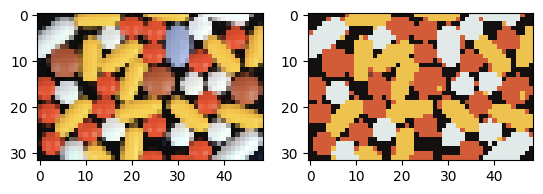

In [51]:
# loading the reduced resolution image.
image_2 =  cv2.cvtColor(cv2.imread('images/pills_res.png'), cv2.COLOR_BGR2RGB)
# -------------------------------
# Implement your code here 
# Note: You are allowed to define your own functions
# -------------------------------
def gaussian_kernel(diff, h):
    return np.exp(-np.sum(diff**2, axis=1) / (h**2))

def mean_shift(image, h=0.5, max_iter=100):
    img = image.astype(np.float32) / 255.0
    flat = img.reshape(-1, 3)
    shifted = flat.copy()

    for iter in range(max_iter):
        for i in range(shifted.shape[0]):
            diff = shifted[i] - flat
            weights = gaussian_kernel(diff, h)
            numerator = np.sum(weights[:, np.newaxis] * flat, axis=0)
            denominator = np.sum(weights)
            shifted[i] = numerator / denominator if denominator > 0 else shifted[i]

    return shifted.reshape(img.shape)

output_2 = mean_shift(image_2, h=0.2, max_iter=10)
# -------------------------------


# -------------------------------
# Show images
# -------------------------------
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image_2)
ax2.imshow(output_2) 
# -------------------------------

## Q3 Histogram-based Thresholding for Image Segmentation

#### Task
Implement a histogram-based binary thresholding algorithm to segment ``image_3`` and ```image_4``` for which you can assume two classes of pixels that correspond to the foreground and background regions following a bi-modal histogram. The goal is to find the optimum threshold that will yield two classes with minimum intra-class variance (equivalently maximum inter-class variance).

#### Description
Let the input image be $I$ and $p(t)$ be the histogram of the image $I$. Here $0 \leq t < L$ and $L$ is the number of bins in the histogram. Note that, $p(t)$ is a normalized histogram. That is, after computing the standard histogram, you need to divide each bin count by the total number of pixels in image $I$.

The implementation focuses on finding the threshold such that it maximizes inter-class variance variance $\sigma(t)$. Inter-class variance for threshold $t$ is given by,

$$ \sigma(t) = w_1(t)w_2(t)[\mu_1(t)-\mu_2(t)]^2$$
The weights $w_1(t)$ and $w_2(t)$ corresponds to the foreground and background and are given by the following equeations,
$$ w_1(t) =  \sum_{i=0}^{t-1}{p(i)}$$
$$ w_2(t) =  \sum_{i=t}^{L-1}{p(i)}$$
$\mu_1$ and $\mu_2$ correponds to two class means and are computed as follows,

$$\mu_1(t) = \frac{1}{w_1(t)}  \sum_{i=0}^{t-1}{ip(i)}$$
$$\mu_2(t) = \frac{1}{w_2(t)}  \sum_{i=t}^{L-1}{ip(i)}$$

 
**input:**
- ``image``: the graysale input to segment

**output:**
- ``image_binary``: binarized image result


#### Note
- **You are expected to maximize the inter-class variance to find the optimum threshold.**

In [52]:
def histogram_based_thresholding(image):
    # -------------------------------
    # Implement your code here
    # -------------------------------
    image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image
    hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 256), density=False)
    hist = hist / hist.sum()

    max_var = 0
    optimal_thresh = 0

    for t in range(1, 256):
        w1 = np.sum(hist[:t])
        w2 = np.sum(hist[t:])
        if w1 == 0 or w2 == 0:
            continue
        mu1 = np.sum(np.arange(0, t) * hist[:t]) / w1
        mu2 = np.sum(np.arange(t, 256) * hist[t:]) / w2
        sigma_b = w1 * w2 * (mu1 - mu2) ** 2

        if sigma_b > max_var:
            max_var = sigma_b
            optimal_thresh = t

    image_binary = (image >= optimal_thresh).astype(np.uint8)
    # -------------------------------
    return image_binary

(np.float64(-0.5), np.float64(1199.5), np.float64(599.5), np.float64(-0.5))

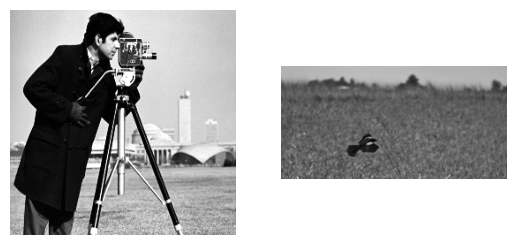

In [53]:
# ----------------------------------------
# Input images - Visualization
# ----------------------------------------
image3 = io.imread("images/photographer.png", as_gray=True)
image4 = io.imread("images/black_bird.jpg", as_gray=True)
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image3, cmap='gray')
ax1.axis('off')
ax2.imshow(image4, cmap='gray')
ax2.axis('off')
# ----------------------------------------

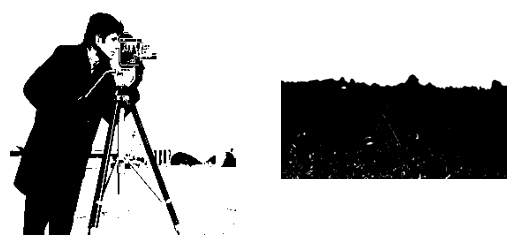

In [54]:
# ----------------------------------------
# Binary output images - Visualization
# ----------------------------------------
image_binary3 = histogram_based_thresholding(image3)
image_binary4 = histogram_based_thresholding(image4)
fig = plt.figure(2)
ax1 = fig.add_subplot(121)
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax1.imshow(image_binary3, cmap='gray')
ax2.imshow(image_binary4, cmap='gray')
# ----------------------------------------

## Q4 Discussion
What might be the reason of having poor segmentation result on the second image in Q3 using the histogram-based thresholding algorithm we asked you to implement? Discuss the possible solutions.

It is because foreground and background of the second image has low contrast. The bird is dark but small, and the background (grass field) varies in texture and intensity, so there is no distinct peak for the bird pixels in the histogram. Therefore the bird pixels are grouped into the same class as the background. Moreover, the bird occupies a very small portion of the image. Histogram methods weigh all pixels equally, so a small object like the bird has little influence on the histogram, occluding the bird. 

One possible solution is to use adaptive thresholding instead, which calculates a local threshold for each region in the image. This method is more robust in situations where the contrast varies across the image, making it suitable for detecting small or low-contrast objects like the bird. Edge detection techniques, such as the Canny or Sobel operator, can also help highlight object boundaries based on intensity gradients, which may work well even when the object itself has low contrast with the background. Additionally, deep learning-based segmentation methods, such as U-Net or other convolutional neural networks, can learn to distinguish small and subtle objects from complex backgrounds. These models are especially effective when trained with labeled examples of similar scenes.